<a href="https://colab.research.google.com/github/Yogibear102/Machine-Learning/blob/main/Banana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import yfinance as yf

from datetime import datetime

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [3]:
symbol = "BTC-USD"
start_date = "2019-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

df = yf.download(symbol, start=start_date, end=end_date, interval="1d")

df.head()


/tmp/ipython-input-4003186635.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2019-01-01,3843.520020,3850.913818,3707.231201,3746.713379,4324200990
2019-01-02,3943.409424,3947.981201,3817.409424,3849.216309,5244856836
2019-01-03,3836.741211,3935.685059,3826.222900,3931.048584,4530215219
2019-01-04,3857.717529,3865.934570,3783.853760,3832.040039,4847965467
2019-01-05,3845.194580,3904.903076,3836.900146,3851.973877,5137609824


Now to format the data

In [4]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

print("Shape:", df.shape)
df.tail()


Shape: (2602, 5)


Price,Open,High,Low,Close,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2026-02-10,70137.390625,70464.265625,67913.093750,68793.960938,40593063077
2026-02-11,68791.859375,69242.679688,65757.304688,66991.968750,49671946030
2026-02-12,66992.195312,68339.492188,65092.109375,66221.843750,44651071271
2026-02-13,66213.375000,69382.835938,65835.781250,68857.843750,40820775886
2026-02-14,68856.984375,70481.164062,68706.617188,69767.625000,36012397645


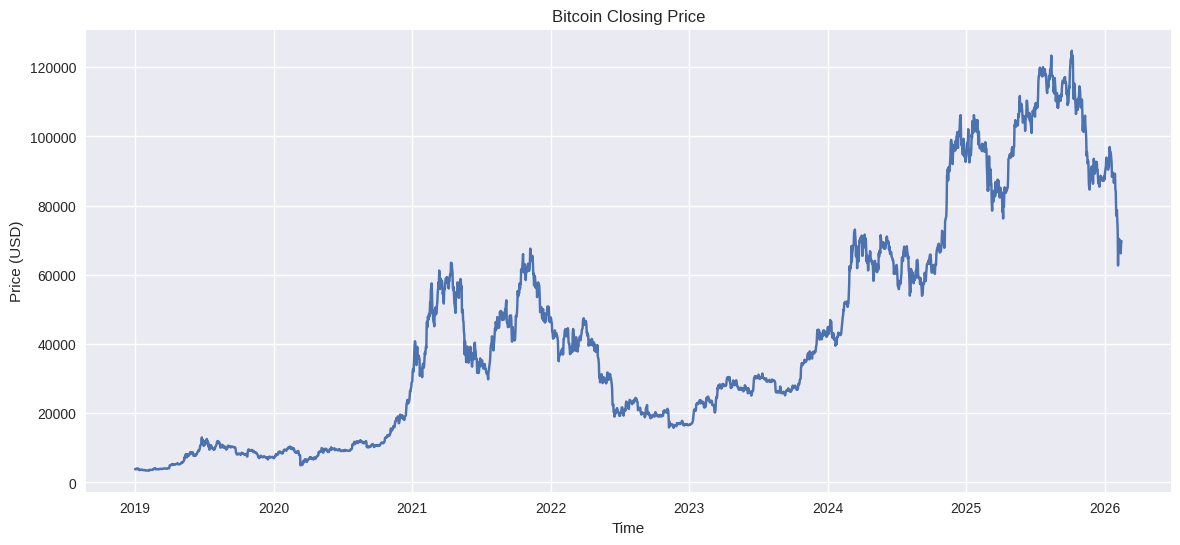

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"])
plt.title("Bitcoin Closing Price")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.show()


# Test for stationarity

In [6]:
def adf_test(series, label=""):
    result = adfuller(series)
    print(f"ADF Statistic ({label}): {result[0]:.4f}")
    print(f"p-value ({label}): {result[1]:.6f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    print()


adf_test(df["Close"], "BTC Close Price")


ADF Statistic (BTC Close Price): -1.3579
p-value (BTC Close Price): 0.602292
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674



as we can observe the p-value is above 0.05 , thus proving the bitcoin value is non-stationary

In [7]:
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df.dropna(inplace=True)

df[["Close", "log_return"]].head()


Price,Close,log_return
Ticker,BTC-USD,
Date,,
2019-01-02,3943.409424,0.025657
2019-01-03,3836.741211,-0.027422
2019-01-04,3857.717529,0.005452
2019-01-05,3845.194580,-0.003251
2019-01-06,4076.632568,0.058447


we have log transformed the function so that it is Homoscedastic for ARIMA

In [8]:
adf_test(df["log_return"], "BTC Log Returns")


ADF Statistic (BTC Log Returns): -24.3515
p-value (BTC Log Returns): 0.000000
Critical Values:
   1%: -3.4329
   5%: -2.8627
   10%: -2.5674



post log transform , we can observe p-value to be below 0.05 thus becoming stationary

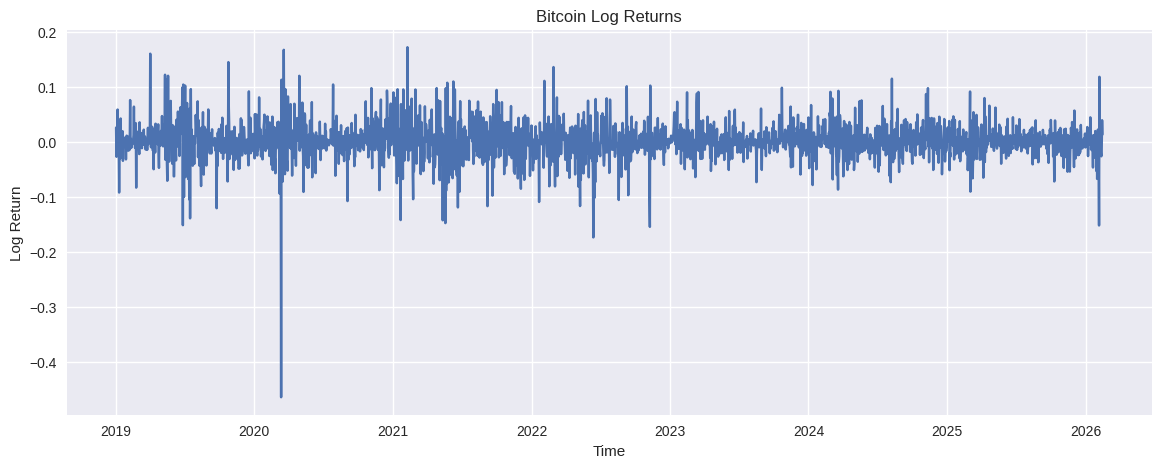

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["log_return"])
plt.title("Bitcoin Log Returns")
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.show()


# Auto-correlation


we check how many steps to look back for prediction using LSTM , this step utilises ACF and PACF

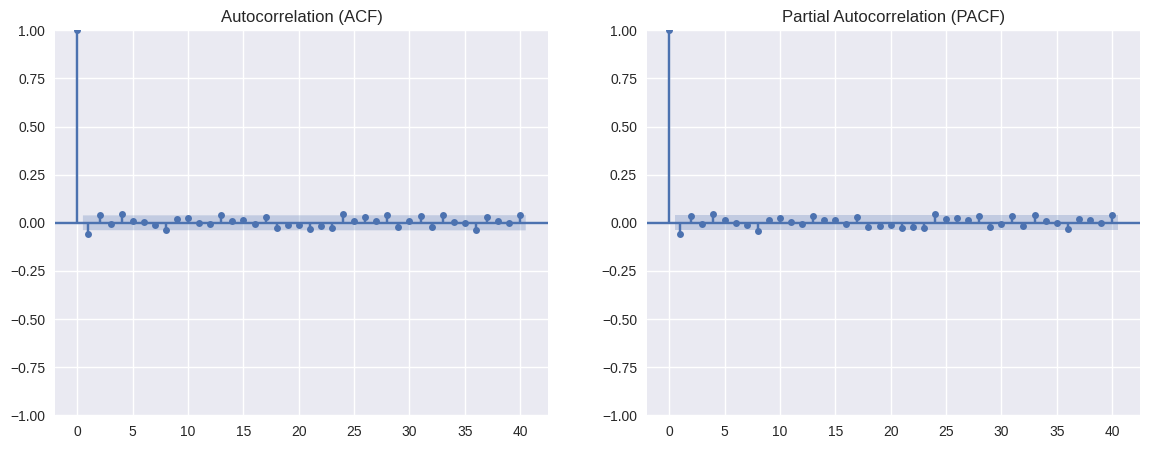

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df["log_return"], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(df["log_return"], lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.show()


This shows that LSTM analysis wouldn't work due to the following reasons :

- Bitcoin log returns are very weakly autocorrelated.

- There is no strong linear memory in returns.

- Market is close to weak-form efficient.

# Building features for Classification model

In [11]:
def build_features(df, window=14):
    data = df.copy()

    data["return"] = data["Close"].pct_change()
    data["volatility"] = data["return"].rolling(window).std()

    data["sma"] = data["Close"].rolling(window).mean()
    data["ema"] = data["Close"].ewm(span=window).mean()

    data["high_low_range"] = (data["High"] - data["Low"]) / data["Close"]
    data["open_close_range"] = (data["Close"] - data["Open"]) / data["Open"]

    for lag in range(1, 6):
        data[f"return_lag_{lag}"] = data["return"].shift(lag)

    return data

In [12]:
df_feat = build_features(df)

df_feat = df_feat.dropna().reset_index(drop=True)

df_feat.head()


Price,Open,High,Low,Close,Volume,log_return,return,volatility,sma,ema,high_low_range,open_close_range,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,,
0,3631.509766,3685.777100,3624.673340,3655.006836,5394457145,0.006679,0.006702,0.034275,3805.711217,3743.410889,0.016718,0.006470,-0.020339,0.043091,-0.029593,-0.007069,0.002294
1,3651.871094,3680.135986,3621.960938,3678.563965,5464420383,0.006424,0.006445,0.033772,3794.412842,3733.789981,0.015815,0.007309,0.006702,-0.020339,0.043091,-0.029593,-0.007069
2,3677.990479,3682.520020,3637.080811,3657.839355,5002961727,-0.005650,-0.005634,0.033702,3780.135829,3722.688545,0.012422,-0.005479,0.006445,0.006702,-0.020339,0.043091,-0.029593
3,3652.377930,3758.533447,3652.377930,3728.568359,5955691380,0.019152,0.019336,0.034239,3771.805385,3723.537087,0.028471,0.020860,-0.005634,0.006445,0.006702,-0.020339,0.043091
4,3725.446045,3743.387939,3583.019531,3601.013672,5582489560,-0.034809,-0.034210,0.030180,3737.832607,3706.047243,0.044534,-0.033401,0.019336,-0.005634,0.006445,0.006702,-0.020339


# Labelling and classification

In [13]:
horizon = 3

df_feat["future_return"] = df_feat["Close"].shift(-horizon) / df_feat["Close"] - 1
df_feat["label"] = (df_feat["future_return"] > 0).astype(int)

df_feat = df_feat.dropna().reset_index(drop=True)

df_feat["label"].value_counts(normalize=True)


,proportion
label,
1,0.530573
0,0.469427


basically defines the threshold for classification

# Test-Train split

In [18]:
feature_columns = [c for c in df_feat.columns
                   if c not in ["timestamp", "label", "future_return"]]

X = df_feat[feature_columns]
y = df_feat["label"]

split_index = int(len(df_feat) * 0.8)

X_train = X.iloc[:split_index].copy()
X_test  = X.iloc[split_index:].copy()

y_train = y.iloc[:split_index].copy()
y_test  = y.iloc[split_index:].copy()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [19]:
print(X_train_scaled.mean(axis=0).mean())
print(X_train_scaled.std(axis=0).mean())


1.8816093631515395e-17
1.0


we need to scale these features so that when we implement logistic regression ,it converges faster

In [16]:
from sklearn.preprocessing import StandardScaler


In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.metrics import classification_report

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_model.fit(X_train_scaled, y_train)

log_preds = log_model.predict(X_test_scaled)
log_probs = log_model.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, log_preds))
print("ROC AUC:", roc_auc_score(y_test, log_probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       276

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517

ROC AUC: 1.0


# XGboost

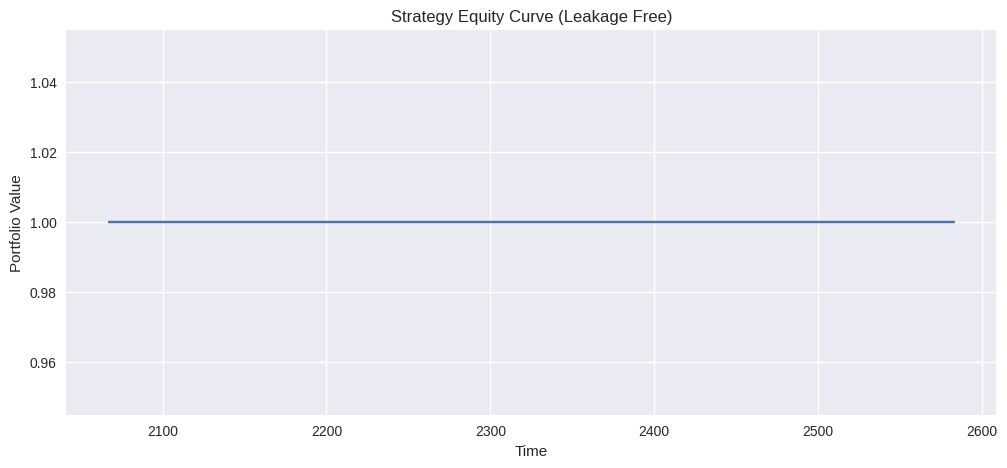

Final Equity: 1.0


In [28]:
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.60
signals = (xgb_probs > threshold).astype(int)

test_df = df_feat.iloc[split_index:].copy()
test_df["signal"] = signals

test_df["strategy_return"] = test_df["signal"] * test_df["future_return"]

equity_curve = (1 + test_df["strategy_return"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(equity_curve)
plt.title("Strategy Equity Curve (Leakage Free)")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.show()

print("Final Equity:", equity_curve.iloc[-1])


In [25]:
from xgboost import XGBClassifier

In [27]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, xgb_preds))
print("ROC AUC:", roc_auc_score(y_test, xgb_probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       276

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517

ROC AUC: 1.0


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=20,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_test, rf_probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       276

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517

ROC AUC: 1.0


# Signal Generation

In [31]:
threshold = 0.60

signals = (xgb_probs > threshold).astype(int)

pd.Series(signals).value_counts()


,count
0,517


# Interpretation and Trading Strategy

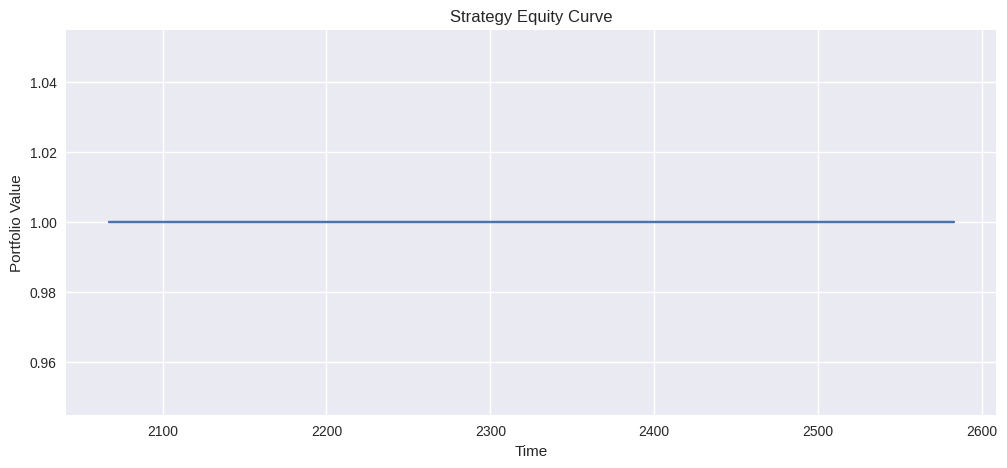

Total Return: 1.0


In [32]:
test_df = df_feat.iloc[split_index:].copy()
test_df["signal"] = signals

test_df["strategy_return"] = test_df["signal"] * test_df["future_return"]

equity_curve = (1 + test_df["strategy_return"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(equity_curve)
plt.title("Strategy Equity Curve")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.show()

print("Total Return:", equity_curve.iloc[-1])


# Dynamic Model Selection for higher returns compared against XGBoost as baseline

In [34]:
model_probabilities = pd.DataFrame({
    "xgb_probs": xgb_probs,
    "rf_probs": rf_probs,
    "log_probs": log_probs,
    "y_test": y_test.values,
    "future_return": test_df["future_return"].values
}, index=y_test.index)

print("Shape:", model_probabilities.shape)
model_probabilities.head()

Shape: (517, 5)


,xgb_probs,rf_probs,log_probs,y_test,future_return
2067,0.001099,0.014144,0.001407,0,-0.039273
2068,0.001108,0.970509,0.994710,1,0.005057
2069,0.004795,0.976618,0.998203,1,0.041682
2070,0.004787,0.988534,0.999434,1,0.081590
2071,0.004915,0.975700,0.998380,1,0.047828


Defining Rolling window


In [36]:
rolling_window = 20

model_probabilities['xgb_rolling_corr'] = model_probabilities['xgb_probs'].rolling(window=rolling_window).corr(model_probabilities['y_test'])
model_probabilities['rf_rolling_corr'] = model_probabilities['rf_probs'].rolling(window=rolling_window).corr(model_probabilities['y_test'])
model_probabilities['log_rolling_corr'] = model_probabilities['log_probs'].rolling(window=rolling_window).corr(model_probabilities['y_test'])

print("Shape:", model_probabilities.shape)
model_probabilities.head(25)

Shape: (517, 8)


,xgb_probs,rf_probs,log_probs,y_test,future_return,xgb_rolling_corr,rf_rolling_corr,log_rolling_corr
2067,0.001099,0.014144,0.001407,0,-0.039273,NaN,NaN,NaN
2068,0.001108,0.970509,0.994710,1,0.005057,NaN,NaN,NaN
2069,0.004795,0.976618,0.998203,1,0.041682,NaN,NaN,NaN
2070,0.004787,0.988534,0.999434,1,0.081590,NaN,NaN,NaN
2071,0.004915,0.975700,0.998380,1,0.047828,NaN,NaN,NaN
2072,0.004927,0.971774,0.997276,1,0.028308,NaN,NaN,NaN
2073,0.004832,0.919192,0.995775,1,0.011253,NaN,NaN,NaN
2074,0.001096,0.902013,0.994343,1,0.002165,NaN,NaN,NaN
2075,0.004787,0.898300,0.995845,1,0.014309,NaN,NaN,NaN
2076,0.001098,0.042068,0.003519,0,-0.007943,NaN,NaN,NaN


Setting correlation threshold to select appropriate model


In [37]:
correlation_threshold = 0.1
model_probabilities['selected_model'] = 'None'

print("Correlation threshold:", correlation_threshold)
print("Shape:", model_probabilities.shape)
model_probabilities.head()

Correlation threshold: 0.1
Shape: (517, 9)


,xgb_probs,rf_probs,log_probs,y_test,future_return,xgb_rolling_corr,rf_rolling_corr,log_rolling_corr,selected_model
2067,0.001099,0.014144,0.001407,0,-0.039273,NaN,NaN,NaN,None
2068,0.001108,0.970509,0.994710,1,0.005057,NaN,NaN,NaN,None
2069,0.004795,0.976618,0.998203,1,0.041682,NaN,NaN,NaN,None
2070,0.004787,0.988534,0.999434,1,0.081590,NaN,NaN,NaN,None
2071,0.004915,0.975700,0.998380,1,0.047828,NaN,NaN,NaN,None


In [38]:
model_columns = ['xgb_rolling_corr', 'rf_rolling_corr', 'log_rolling_corr']

for index, row in model_probabilities.iterrows():
    valid_correlations = {}
    for col in model_columns:
        if pd.notna(row[col]) and row[col] > correlation_threshold:
            valid_correlations[col.replace('_rolling_corr', '')] = row[col]

    if valid_correlations:
        selected = max(valid_correlations, key=valid_correlations.get)
        model_probabilities.loc[index, 'selected_model'] = selected

print("Shape:", model_probabilities.shape)
model_probabilities.head(25)

Shape: (517, 9)


,xgb_probs,rf_probs,log_probs,y_test,future_return,xgb_rolling_corr,rf_rolling_corr,log_rolling_corr,selected_model
2067,0.001099,0.014144,0.001407,0,-0.039273,NaN,NaN,NaN,None
2068,0.001108,0.970509,0.994710,1,0.005057,NaN,NaN,NaN,None
2069,0.004795,0.976618,0.998203,1,0.041682,NaN,NaN,NaN,None
2070,0.004787,0.988534,0.999434,1,0.081590,NaN,NaN,NaN,None
2071,0.004915,0.975700,0.998380,1,0.047828,NaN,NaN,NaN,None
2072,0.004927,0.971774,0.997276,1,0.028308,NaN,NaN,NaN,None
2073,0.004832,0.919192,0.995775,1,0.011253,NaN,NaN,NaN,None
2074,0.001096,0.902013,0.994343,1,0.002165,NaN,NaN,NaN,None
2075,0.004787,0.898300,0.995845,1,0.014309,NaN,NaN,NaN,None
2076,0.001098,0.042068,0.003519,0,-0.007943,NaN,NaN,NaN,None


Dynamic Signal generation

In [40]:
model_probabilities['dynamic_signal'] = 0
signal_threshold = 0.60

for index, row in model_probabilities.iterrows():
    if row['selected_model'] != 'None':
        model_type = row['selected_model']
        prob_col = f'{model_type}_probs'

        if row[prob_col] > signal_threshold:
            model_probabilities.loc[index, 'dynamic_signal'] = 1

print("Dynamic signal counts:")
print(model_probabilities['dynamic_signal'].value_counts())

print("Shape:", model_probabilities.shape)
model_probabilities.head()

Dynamic signal counts:
dynamic_signal
1    263
0    254
Name: count, dtype: int64
Shape: (517, 10)


,xgb_probs,rf_probs,log_probs,y_test,future_return,xgb_rolling_corr,rf_rolling_corr,log_rolling_corr,selected_model,dynamic_signal
2067,0.001099,0.014144,0.001407,0,-0.039273,NaN,NaN,NaN,None,0
2068,0.001108,0.970509,0.994710,1,0.005057,NaN,NaN,NaN,None,0
2069,0.004795,0.976618,0.998203,1,0.041682,NaN,NaN,NaN,None,0
2070,0.004787,0.988534,0.999434,1,0.081590,NaN,NaN,NaN,None,0
2071,0.004915,0.975700,0.998380,1,0.047828,NaN,NaN,NaN,None,0


In [41]:
model_probabilities['dynamic_strategy_return'] = model_probabilities['dynamic_signal'] * model_probabilities['future_return']
dynamic_equity_curve = (1 + model_probabilities['dynamic_strategy_return']).cumprod()

print("Shape:", model_probabilities.shape)
model_probabilities.head()

Shape: (517, 11)


,xgb_probs,rf_probs,log_probs,y_test,future_return,xgb_rolling_corr,rf_rolling_corr,log_rolling_corr,selected_model,dynamic_signal,dynamic_strategy_return
2067,0.001099,0.014144,0.001407,0,-0.039273,NaN,NaN,NaN,None,0,-0.0
2068,0.001108,0.970509,0.994710,1,0.005057,NaN,NaN,NaN,None,0,0.0
2069,0.004795,0.976618,0.998203,1,0.041682,NaN,NaN,NaN,None,0,0.0
2070,0.004787,0.988534,0.999434,1,0.081590,NaN,NaN,NaN,None,0,0.0
2071,0.004915,0.975700,0.998380,1,0.047828,NaN,NaN,NaN,None,0,0.0


Final estimates and plot against xgboost curve

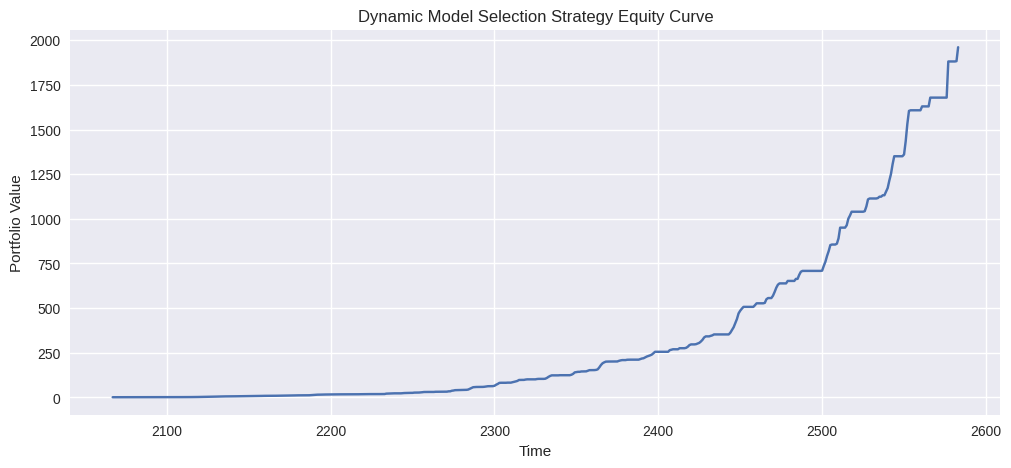

Final Equity: 1961.1100328878138


In [42]:
plt.figure(figsize=(12,5))
plt.plot(dynamic_equity_curve)
plt.title("Dynamic Model Selection Strategy Equity Curve")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.show()

print("Final Equity:", dynamic_equity_curve.iloc[-1])

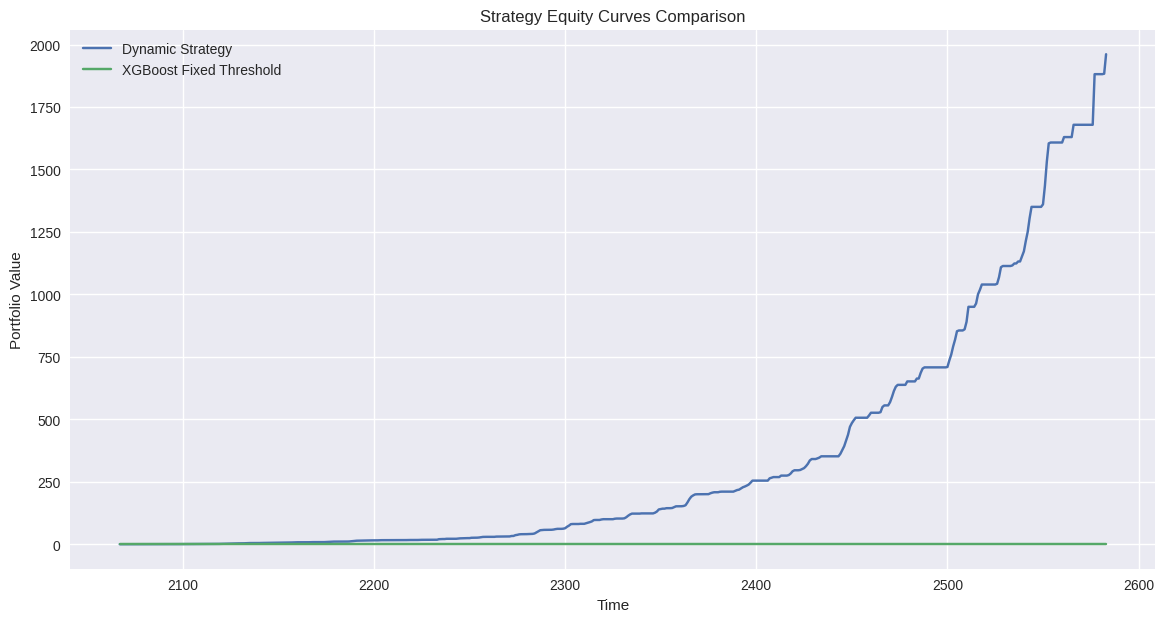

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(dynamic_equity_curve, label='Dynamic Strategy')
plt.plot(equity_curve, label='XGBoost Fixed Threshold')
plt.title('Strategy Equity Curves Comparison')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()